## Forecasting

#### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


#### Import Data

In [97]:
df = pd.read_csv('segments_df.csv')

In [98]:
regions_df = pd.read_excel('Regions_df.xlsx')

In [99]:
df.head()

,InvoiceDate,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country,Sale_Total,cleaned_description,segment
0,2010-12-01 08:26:00,536365.0,85123A,6.0,2.55,17850.0,United Kingdom,15.30,hanging heart tlight holder,3
1,2010-12-01 08:26:00,536365.0,71053.0,6.0,3.39,17850.0,United Kingdom,20.34,metal lantern,2
2,2010-12-01 08:26:00,536365.0,84406B,8.0,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,2
3,2010-12-01 08:26:00,536365.0,84029G,6.0,3.39,17850.0,United Kingdom,20.34,knitted union flag hot water bottle,3
4,2010-12-01 08:26:00,536365.0,84029E,6.0,3.39,17850.0,United Kingdom,20.34,woolly hottie heart,0


In [100]:
regions_df.head()

,Country,Region
0,United Kingdom,Domestic/UK
1,France,Europe
2,EIRE,Europe
3,Spain,Europe
4,Australia,Asia/South Pacific


In [101]:
df = df.merge(regions_df, how = 'left', on = 'Country')

In [54]:
df.head()

,InvoiceDate,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country,Sale_Total,cleaned_description,segment,Region
0,2010-12-01 08:26:00,536365.0,85123A,6.0,2.55,17850.0,United Kingdom,15.30,hanging heart tlight holder,3,Domestic/UK
1,2010-12-01 08:26:00,536365.0,71053.0,6.0,3.39,17850.0,United Kingdom,20.34,metal lantern,2,Domestic/UK
2,2010-12-01 08:26:00,536365.0,84406B,8.0,2.75,17850.0,United Kingdom,22.00,cream cupid heart coat hanger,2,Domestic/UK
3,2010-12-01 08:26:00,536365.0,84029G,6.0,3.39,17850.0,United Kingdom,20.34,knitted union flag hot water bottle,3,Domestic/UK
4,2010-12-01 08:26:00,536365.0,84029E,6.0,3.39,17850.0,United Kingdom,20.34,woolly hottie heart,0,Domestic/UK


In [102]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)

## Prepare Data for Forecasting

In [103]:
sales_df = df[['InvoiceDate','Sale_Total']]
sales_df.head()

,InvoiceDate,Sale_Total
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34


In [104]:
sales_df.columns = ['ds','y']
sales_df.head()

,ds,y
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34


In [64]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523695 entries, 0 to 523694
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      523695 non-null  datetime64[ns]
 1   y       523695 non-null  float64       
 2   regr1   523695 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 16.0+ MB


In [105]:
agg_sales_data = sales_df.resample('D', on='ds')['y'].sum()
forecast_df = pd.DataFrame(agg_sales_data)

In [66]:
forecast_df[forecast_df['y'] == 0]

,y
ds,
2010-12-04,0.0
2010-12-11,0.0
2010-12-18,0.0
2010-12-24,0.0
2010-12-25,0.0
...,...
2011-11-05,0.0
2011-11-12,0.0
2011-11-19,0.0


In [106]:
forecast_df.reset_index(inplace=True)

In [107]:
forecast_df.head()

,ds,y
0,2010-12-01,56179.72
1,2010-12-02,47511.63
2,2010-12-03,40500.47
3,2010-12-04,0.00
4,2010-12-05,31419.16


In [108]:
len(forecast_df)

374

In [116]:
#exclude final 4 weeks from training data
#374-(7*4) = 345
train_data = forecast_df[:346]
test_data = forecast_df[346:]

In [117]:
len(test_data)

28

In [165]:
forecast_df[:(len(forecast_df)-28)]

,ds,y
0,2010-12-01,56179.72
1,2010-12-02,47511.63
2,2010-12-03,40500.47
3,2010-12-04,0.00
4,2010-12-05,31419.16
...,...,...
341,2011-11-07,78610.02
342,2011-11-08,54182.79
343,2011-11-09,63770.25
344,2011-11-10,69785.14


## Create Model for All Data

In [142]:
#train model on test data and show daily estimates
model = Prophet(seasonality_mode='multiplicative')
model.fit(train_data)
daily_future = model.make_future_dataframe(periods=28, freq='D')
daily_forecast = model.predict(daily_future)
weekly_future = model.make_future_dataframe(periods=5, freq='w')
weekly_forecast = model.predict(weekly_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.cond

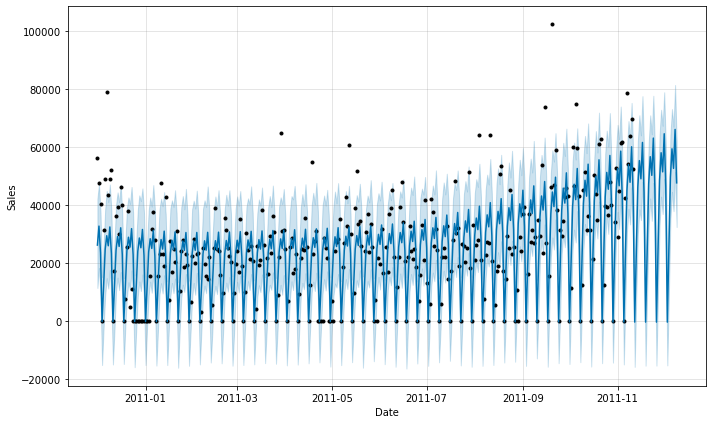

In [166]:
#Plot daily predictions
figure = model.plot(daily_forecast,xlabel='Date',ylabel='Sales')
plt.show(figure)

The default prediction interval is .80. There is considerable noise in the data, with some unexpectedly high days. However, the aim of my project is to forecast on a weekly basis. Given that most of the data is falling within the intervals, when the high daily values are aggregated with the rest of the week the model is likely to perform fairly well.

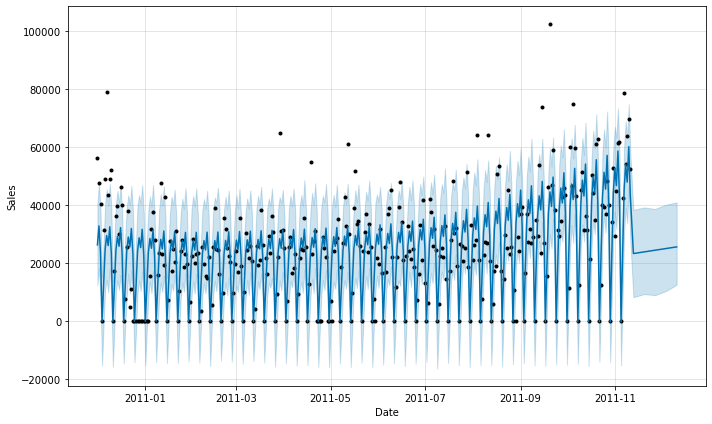

In [143]:
#Plot weekly aggregate predictions
figure2 = model.plot(weekly_forecast,xlabel='Date',ylabel='Sales')

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


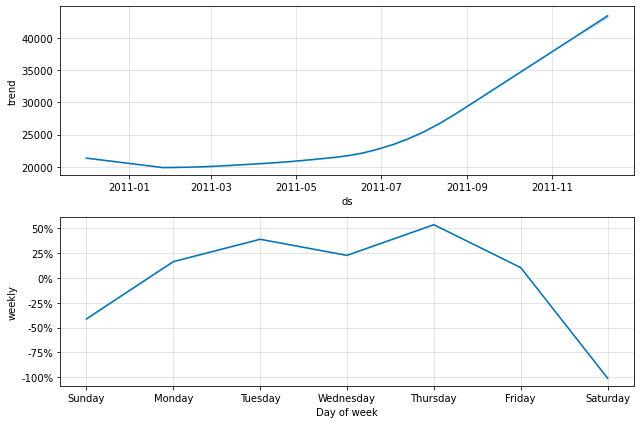

In [144]:
figure3 = model.plot_components(weekly_forecast)

<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='ds'>

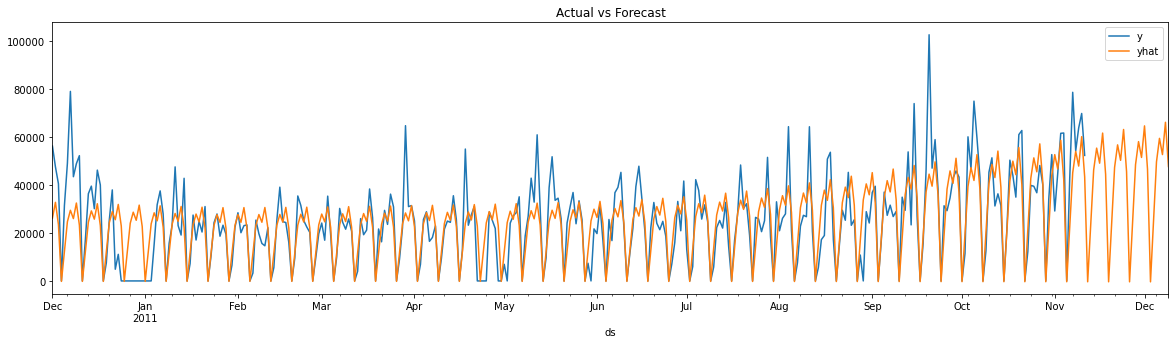

In [131]:
# plotting the actual and forecast values

ax = (train_data.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
daily_forecast.plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast', ax=ax)

#### Create Error Metrics

In [162]:
def mean_absolute_percentage_error(y, y_pred):
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y-y_pred)/ y)) *100

In [161]:
def root_mean_square_error(y, y_pred):
    y, y_pred = np.array(y), np.array(y_pred)
    return np.sqrt(np.mean((y-y_pred) **2))

In [138]:
#aggregate the test data by week to create target values to compare to predictions
agg_sales_data = test_data.resample('W', on='ds')['y'].sum()
agg_test_data = pd.DataFrame(agg_sales_data)

In [149]:
agg_test_data[1:]['y']

ds
2011-11-20    368182.95
2011-11-27    298706.75
2011-12-04    308453.16
2011-12-11    313574.03
Freq: W-SUN, Name: y, dtype: float64

In [200]:
#aggregate the model predictions by week
agg_predictions = daily_forecast[346:].resample('W', on='ds')['yhat'].sum()
agg_weekly_predictions = pd.DataFrame(agg_predictions)

In [244]:
forecast_results_df = agg_test_data.merge(agg_weekly_predictions, how = 'left', on = 'ds')

In [245]:
forecast_results_df['error'] = forecast_results_df['y'] - forecast_results_df['yhat']

In [247]:
forecast_results_df = forecast_results_df[1:]
forecast_results_df

,y,yhat,error
ds,,,
2011-11-20,368182.95,280114.494295,88068.455705
2011-11-27,298706.75,286944.635568,11762.114432
2011-12-04,308453.16,293774.776842,14678.383158
2011-12-11,313574.03,275477.213566,38096.816434


In [163]:
#grab true and predicted values for the last four weeks in the original dataset
y = agg_test_data[1:]['y']
y_pred = agg_weekly_predictions[1:]['yhat']
mean_absolute_percentage_error(y, y_pred)

11.191341601609533

In [164]:
root_mean_square_error(y,y_pred)

48890.7521437587

## Create Functions to automate forecasting and error metrics on Data Segments

In [234]:
def make_forecast(df):
    #isolate relevant columns
    sales_df = df[['InvoiceDate','Sale_Total']]
    
    #rename columns for prophet
    sales_df.columns = ['ds','y']
    
    #convert timestamp to datetime
    sales_df.ds = pd.to_datetime(sales_df.ds)
    
    #aggregate by day
    agg_sales_data = sales_df.resample('D', on='ds')['y'].sum()
    
    #convert series to df and reset index
    forecast_df = pd.DataFrame(agg_sales_data) 
    forecast_df.reset_index(inplace=True)
    
    #Train-test split
    training = forecast_df[:(len(forecast_df)-28)]
    global testing
    testing = forecast_df[(len(forecast_df)-28):]
    
    #train model on test data and show daily estimates
    model = Prophet(seasonality_mode='multiplicative')
    model.fit(training)
    daily_future = model.make_future_dataframe(periods=28, freq='D')
    global daily_forecast_x
    daily_forecast_x = model.predict(daily_future)
    weekly_future = model.make_future_dataframe(periods=5, freq='w')
    weekly_forecast = model.predict(weekly_future)
    
    #Plot daily predictions
    figure = model.plot(daily_forecast_x,xlabel='Date',ylabel='Sales')
    plt.show(figure)
    
    #plot trends
    figure2 = model.plot_components(weekly_forecast)
    plt.show(figure2)
    
    return(weekly_forecast.tail())

In [202]:
def calculate_error(forecast, testing):
    #aggregate the test data by week
    agg_sales_data = testing.resample('W', on='ds')['y'].sum()
    agg_test_data = pd.DataFrame(agg_sales_data)
    
    #aggregate the model predictions by week
    agg_predictions = forecast[(len(forecast)-28):].resample('W', on='ds')['yhat'].sum()
    agg_weekly_predictions = pd.DataFrame(agg_predictions)
    
    y = agg_test_data[1:]['y']
    y_pred = agg_weekly_predictions[1:]['yhat']
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = root_mean_square_error(y, y_pred)
    
    print(f"The mean absolute percentage error is {mape:.2f}%.")
    return(f"The root mean square error is {rmse:.2f}.")

### Regional Forecast

In [208]:
df.Region.value_counts()

Domestic/UK           479468
Europe                 40423
Asia/South Pacific       785
Other                    508
Middle East              364
North America            218
Name: Region, dtype: int64

In [204]:
Sales_Asia = df[df['Region']== 'Asia/South Pacific']

C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\3472696365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.ds = pd.to_datetime(sales_df.ds)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated an

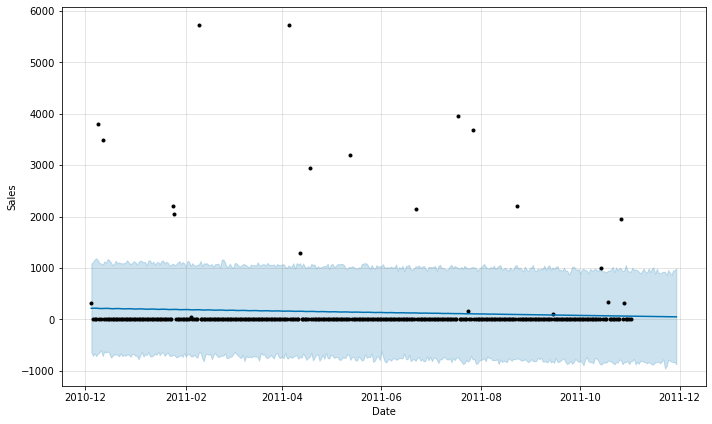

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


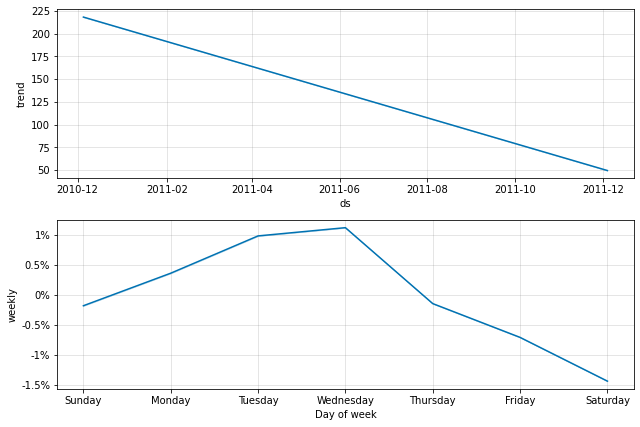

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
332,2011-11-06,62.609769,-869.756188,985.838840,62.609768,62.609769,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,0.0,0.0,0.0,62.497108
333,2011-11-13,59.365596,-863.559747,975.633577,59.365594,59.365597,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,0.0,0.0,0.0,59.258772
334,2011-11-20,56.121423,-795.296173,991.739231,56.121418,56.121426,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,0.0,0.0,0.0,56.020437
335,2011-11-27,52.877250,-846.952968,928.410262,52.877242,52.877256,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,0.0,0.0,0.0,52.782102
336,2011-12-04,49.633077,-823.145346,927.981339,49.633066,49.633087,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,-0.001799,0.0,0.0,0.0,49.543766


In [235]:
make_forecast(Sales_Asia)

In [206]:
calculate_error(daily_forecast_x, testing)

The mean absolute percentage error is inf%.


C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\1981289941.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y-y_pred)/ y)) *100


'The root mean square error is 2842.30.'

Some weekly sales total zero. We need at least some sales every week in order to calculate a MAPE.

In [209]:
European_Sales = df[df['Region']== 'Europe']

C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\3472696365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.ds = pd.to_datetime(sales_df.ds)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated an

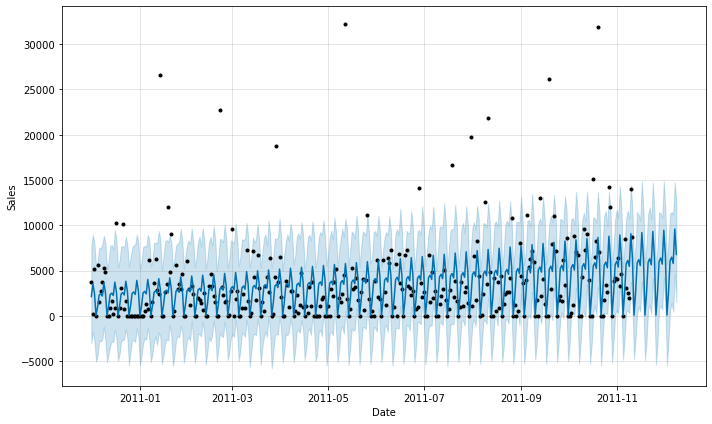

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


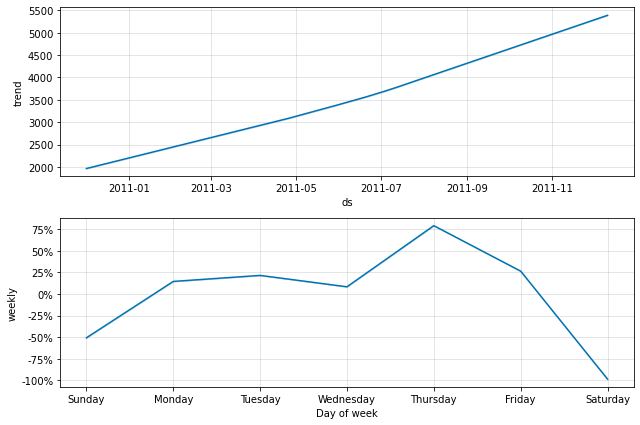

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
346,2011-11-13,5091.538305,-2592.438558,7755.755010,5091.538305,5091.538305,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,0.0,0.0,0.0,2503.320968
347,2011-11-20,5165.826404,-2509.261505,7865.792408,5165.382645,5166.415632,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,0.0,0.0,0.0,2539.845678
348,2011-11-27,5240.114503,-3035.340365,7619.218141,5238.573287,5241.977462,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,0.0,0.0,0.0,2576.370387
349,2011-12-04,5314.402602,-3135.062765,8028.561731,5311.532930,5317.702217,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,0.0,0.0,0.0,2612.895096
350,2011-12-11,5388.690701,-2368.012396,7700.495084,5384.216287,5393.800355,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,-0.508337,0.0,0.0,0.0,2649.419805


In [236]:
make_forecast(European_Sales)

In [211]:
calculate_error(daily_forecast_x, testing)

The mean absolute percentage error is 14.98%.


'The root mean square error is 6721.94.'

In [215]:
Domestic_Sales = df[df['Region']== 'Domestic/UK']

C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\3472696365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.ds = pd.to_datetime(sales_df.ds)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated an

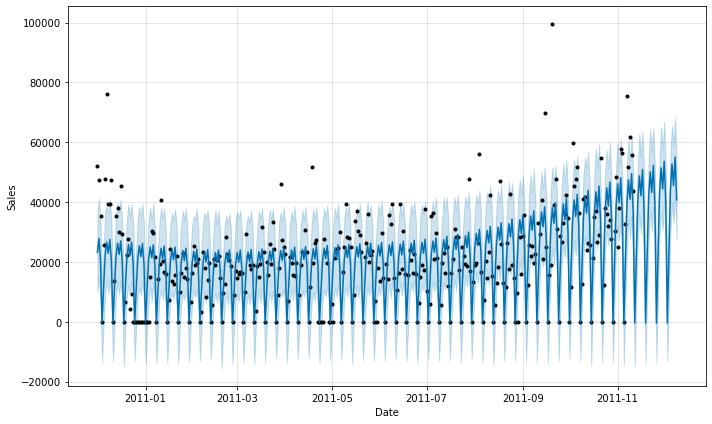

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


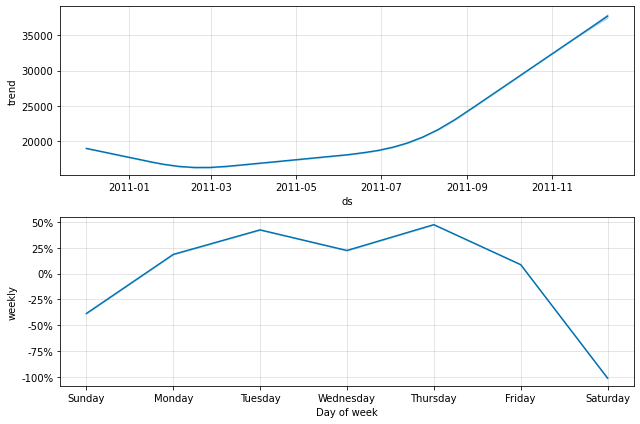

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
346,2011-11-13,33986.437844,7586.417022,34224.758158,33986.437844,33986.437844,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,0.0,0.0,0.0,20876.386086
347,2011-11-20,34925.448266,8628.717746,35155.789505,34901.349466,34959.436271,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,0.0,0.0,0.0,21453.179223
348,2011-11-27,35864.458688,8181.575847,35778.565869,35777.252586,35963.540173,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,0.0,0.0,0.0,22029.972360
349,2011-12-04,36803.469109,9969.496663,36180.359090,36641.440414,36996.772504,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,0.0,0.0,0.0,22606.765497
350,2011-12-11,37742.479531,9694.438231,35461.313073,37487.572481,38038.804053,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,-0.385744,0.0,0.0,0.0,23183.558634


In [237]:
make_forecast(Domestic_Sales)

In [217]:
calculate_error(daily_forecast_x,testing)

The mean absolute percentage error is 12.52%.


'The root mean square error is 42812.76.'

#### Section Conclusion

Because such a vast majority of the data are domestic orders, forecasting by region is not a viable option. Even in Asia, the region with the third most sales, there are many weeks with zero sales. For a more international business this may be a good strategy in order to see the trends in different markets but for this business it doesn't work.

## Forecast by Segment

In [213]:
df.segment.value_counts()

0    118627
3    116009
4    104864
2    100499
1     83696
Name: segment, dtype: int64

In [214]:
Segment_0 = df[df['segment']==0]

C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\3472696365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.ds = pd.to_datetime(sales_df.ds)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated an

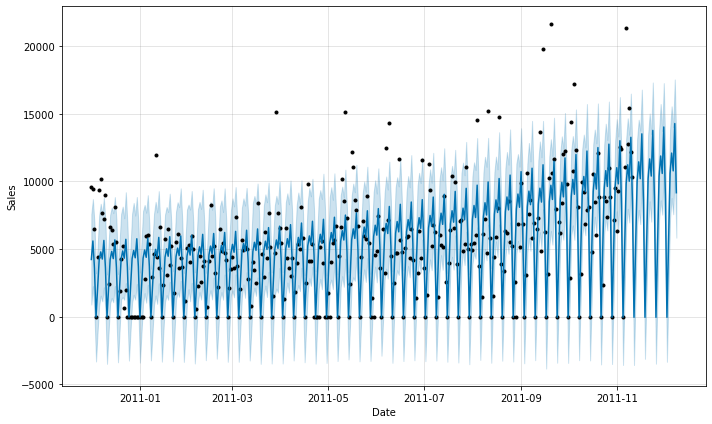

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


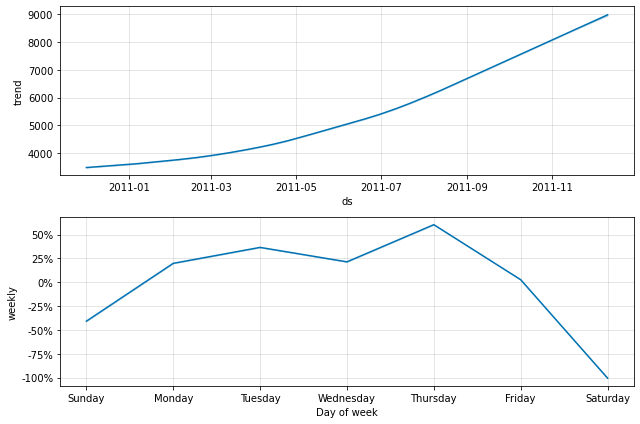

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
346,2011-11-13,8337.475067,1549.682867,8100.692375,8337.475067,8337.475067,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,0.0,0.0,0.0,4940.869642
347,2011-11-20,8495.837297,1682.077030,8375.475446,8491.521713,8498.928097,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,0.0,0.0,0.0,5034.716655
348,2011-11-27,8654.199526,1617.193683,8225.287200,8642.370146,8663.335614,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,0.0,0.0,0.0,5128.563668
349,2011-12-04,8812.561756,1881.509857,8245.338778,8790.587827,8829.471328,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,0.0,0.0,0.0,5222.410682
350,2011-12-11,8970.923986,2308.746298,8625.846714,8938.322440,8999.230463,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,-0.40739,0.0,0.0,0.0,5316.257695


In [238]:
make_forecast(Segment_0)

In [219]:
calculate_error(daily_forecast_x,testing)

The mean absolute percentage error is 10.40%.


'The root mean square error is 11034.08.'

In [220]:
Segment_1 = df[df['segment']==1]

C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\3472696365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.ds = pd.to_datetime(sales_df.ds)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated an

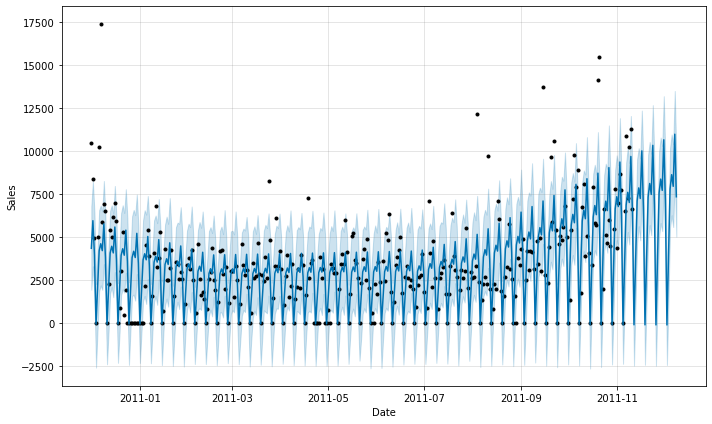

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


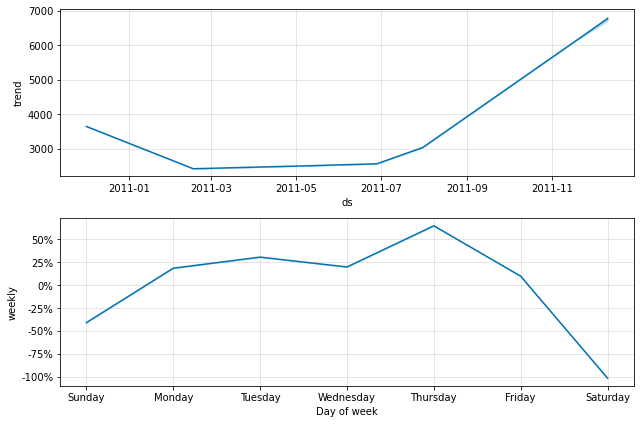

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
346,2011-11-13,5978.735155,1174.842436,5855.343911,5978.735155,5978.735155,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,0.0,0.0,0.0,3526.692460
347,2011-11-20,6175.489944,1203.334342,5955.935990,6170.003908,6182.539289,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,0.0,0.0,0.0,3642.752732
348,2011-11-27,6372.244732,1333.109338,6299.292828,6351.480479,6394.435951,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,0.0,0.0,0.0,3758.813004
349,2011-12-04,6568.999521,1335.578932,6156.122687,6524.810803,6612.064192,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,0.0,0.0,0.0,3874.873276
350,2011-12-11,6765.754310,1570.651078,6369.348896,6697.852937,6833.184052,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,-0.410127,0.0,0.0,0.0,3990.933548


In [239]:
make_forecast(Segment_1)

In [222]:
calculate_error(daily_forecast_x, testing)

The mean absolute percentage error is 13.35%.


'The root mean square error is 8080.76.'

In [223]:
Segment_2 = df[df['segment']==2]

C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\739473750.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.ds = pd.to_datetime(sales_df.ds)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and

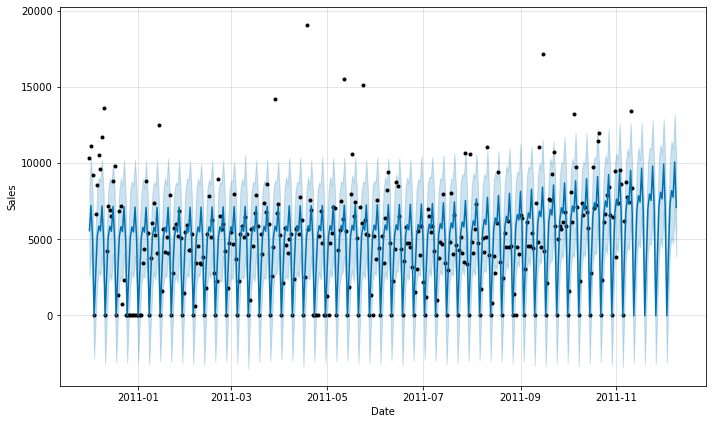

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


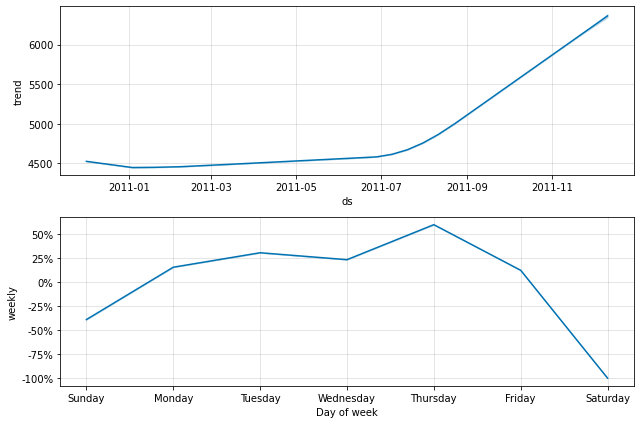

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-12-01,4526.709016,2470.030950,8645.265738,4526.709016,4526.709016,0.230053,0.230053,0.230053,0.230053,0.230053,0.230053,0.0,0.0,0.0,5568.090544
1,2010-12-02,4524.345063,4364.509728,10311.996262,4524.345063,4524.345063,0.594551,0.594551,0.594551,0.594551,0.594551,0.594551,0.0,0.0,0.0,7214.298207
2,2010-12-03,4521.981110,2014.230233,8095.798949,4521.981110,4521.981110,0.119558,0.119558,0.119558,0.119558,0.119558,0.119558,0.0,0.0,0.0,5062.621434
3,2010-12-04,4519.617158,-2805.940373,2899.546067,4519.617158,4519.617158,-1.003679,-1.003679,-1.003679,-1.003679,-1.003679,-1.003679,0.0,0.0,0.0,-16.626179
4,2010-12-05,4517.253205,-141.899545,5794.061695,4517.253205,4517.253205,-0.394003,-0.394003,-0.394003,-0.394003,-0.394003,-0.394003,0.0,0.0,0.0,2737.443075


In [224]:
make_forecast(Segment_2)

In [225]:
calculate_error(daily_forecast_x, testing)

The mean absolute percentage error is 21.38%.


'The root mean square error is 12250.38.'

In [226]:
Segment_3 = df[df['segment']==3]

C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\3472696365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.ds = pd.to_datetime(sales_df.ds)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated an

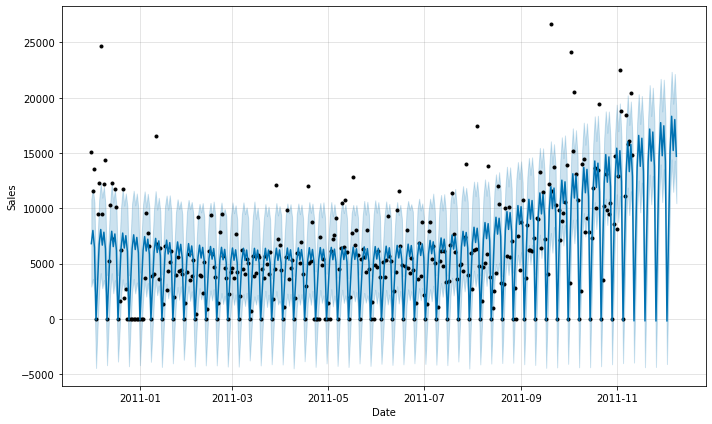

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


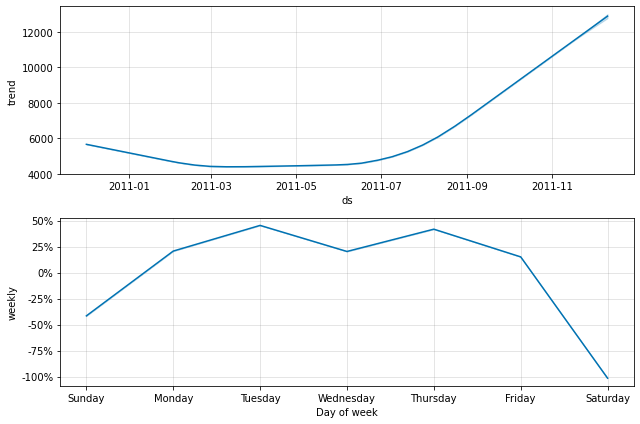

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
346,2011-11-13,11300.924813,2374.025657,10751.670065,11300.924813,11300.924813,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,0.0,0.0,0.0,6596.688029
347,2011-11-20,11698.153934,2957.828869,10900.266104,11682.679940,11709.485056,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,0.0,0.0,0.0,6828.562555
348,2011-11-27,12095.383055,2663.947533,10948.163475,12051.411951,12136.055115,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,0.0,0.0,0.0,7060.437081
349,2011-12-04,12492.612176,3145.193286,11604.641740,12415.175958,12571.050164,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,0.0,0.0,0.0,7292.311608
350,2011-12-11,12889.841298,3098.719543,11571.142674,12772.700681,13008.408736,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,-0.41627,0.0,0.0,0.0,7524.186134


In [240]:
make_forecast(Segment_3)

In [228]:
calculate_error(daily_forecast_x,testing)

The mean absolute percentage error is 9.26%.


'The root mean square error is 12358.30.'

In [229]:
Segment_4 = df[df['segment']==4]

C:\Users\SReed\AppData\Local\Temp\ipykernel_19612\3472696365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.ds = pd.to_datetime(sales_df.ds)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated an

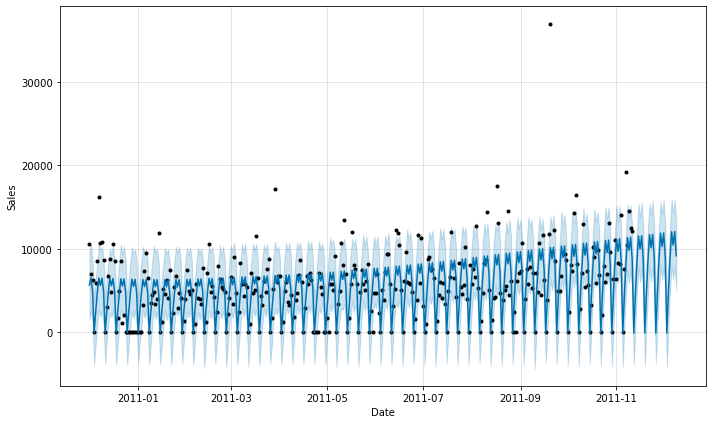

C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\SReed\.conda\envs\cluster\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


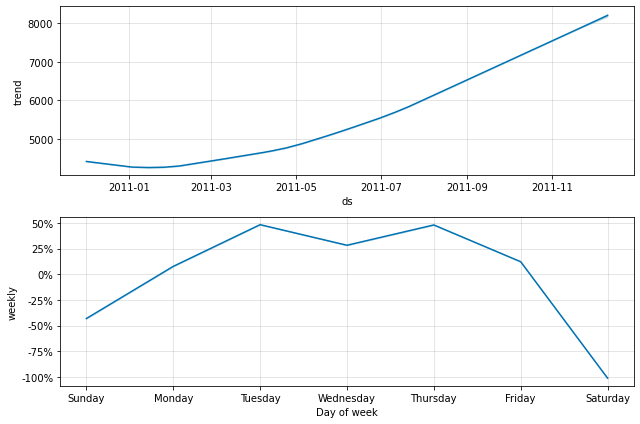

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
346,2011-11-13,7741.582160,159.274420,7852.459010,7741.582160,7741.582160,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,0.0,0.0,0.0,4399.137194
347,2011-11-20,7857.622645,1004.635153,8681.975185,7854.590112,7861.339765,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,0.0,0.0,0.0,4465.076946
348,2011-11-27,7973.663129,720.308175,8758.783649,7963.998648,7985.210128,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,0.0,0.0,0.0,4531.016698
349,2011-12-04,8089.703613,1084.271076,8541.205884,8071.883573,8111.540208,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,0.0,0.0,0.0,4596.956451
350,2011-12-11,8205.744097,819.601353,8433.563512,8175.821695,8240.649432,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,-0.431752,0.0,0.0,0.0,4662.896203


In [241]:
make_forecast(Segment_4)

In [231]:
calculate_error(daily_forecast_x,testing)

The mean absolute percentage error is 15.03%.


'The root mean square error is 13069.85.'

#### Section Conclusion

Since the segmentation from the last section didn't yield any clear results, it is unsurprising that forecasting by segments didn't provide any major insights. Some of the segment models performed a little better, some a little worse than modeling on the whole dataset. The trend lines showed some variation but were generally similar.

## Final Conclusions

By training on all the data except the last 4 weeks, I was able to compare model predictions to unseen data. As seen in the graph below, our model is perhaps slightly underpredicting but performing pretty well. We don't need a daily forecast for this particular business context, an aggregated weekly prediction is sufficient.

<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='ds'>

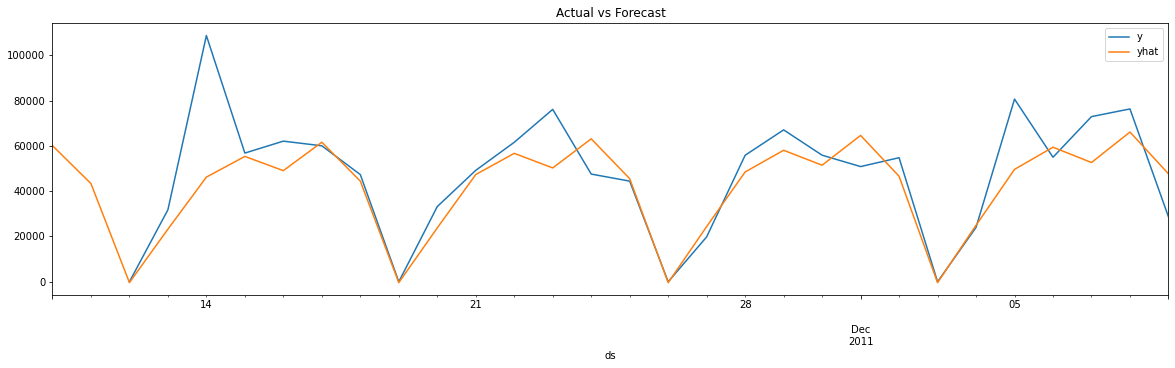

In [243]:
# plotting the holdout test data and forecast values

ax = (test_data.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
daily_forecast[(len(daily_forecast)-30):].plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast', ax=ax)

When the data was aggregated by week the model had a mean absolute percentage error of 11.2% and a root mean square error of 48,891. It is worth noting that all four predicted weeks were lower than their respective actual values, with a majority of the error coming in the first week as a result of one unusually high sales day. The results can be seen in the table below.


In [248]:
forecast_results_df

,y,yhat,error
ds,,,
2011-11-20,368182.95,280114.494295,88068.455705
2011-11-27,298706.75,286944.635568,11762.114432
2011-12-04,308453.16,293774.776842,14678.383158
2011-12-11,313574.03,275477.213566,38096.816434


Ultimately, I would have to work with decision makers in the company to decide whether this model is accurate enough to make it worth using. It may be worth adding 10% to the forecasted numbers and then preparing for weekly sales with some additional buffer. However, there could be legitimate concern that the model is simply not identifying a trend and the predictions could get less accurate week over week.

****

While in the end none of our segments proved useful, by looking at the trend lines created by the Segment_0 model vs that of Segment_1, the underlying potential of the exercise becomes clear. Segment_0's trend line starts below 4,000 and increases throughout the year, while that of Segment_1 starts at nearly 40,000 and continues to decrease until around March when it begins its upward trend. If we imagine that the segmentation model had produced more insightful groupings, it is easy to imagine gaining quick, meaningful insight into how the various segments of the business have performed compared to one another throughout the year. These might be obvious, like selling Christmas products in December, but it is also possible that some unforeseen trends could be uncovered that could lead to the development of new sales and marketing efforts.